<a href="https://colab.research.google.com/github/zhlu97/foundationcv/blob/master/EECS_504_PS5_Scene_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Zhaohan] [Lu], [zhaohan]

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-02-17 07:09:43--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip.1’

data_miniplaces_mod 100%[===================>] 509.86M  11.2MB/s    in 46s     

2020-02-17 07:10:30 (11.0 MB/s) - ‘data_miniplaces_modified.zip.1’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

replace data_miniplaces_modified/test/badlands/00000399.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Step 1: Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I. Resize the image to input_size using transforms.Resize
    # II. Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. 
    tsfm1 = transforms.Resize(input_size)
    tsfm2 = transforms.ToTensor()
    tsfm3 = transforms.Normalize(mean, std, inplace=False)
    data_transform = transforms.Compose([tsfm1, tsfm2, tsfm3])

    # ========= Step 2: build dataloaders for the downloaded data ===========
    # I. use torch.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to contruct pytorch datasets for train/val/test 
    # II. use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. put the dataloaders into a dictionary
    dataloaders_dict = {}
    train_dataset = datasets.ImageFolder(root = 'data_miniplaces_modified/train', transform = data_transform)
    dataloaders_dict['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataset = datasets.ImageFolder(root = 'data_miniplaces_modified/val', transform = data_transform)
    dataloaders_dict['val'] = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dataset = datasets.ImageFolder(root = 'data_miniplaces_modified/train', transform = data_transform)
    dataloaders_dict['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 90000


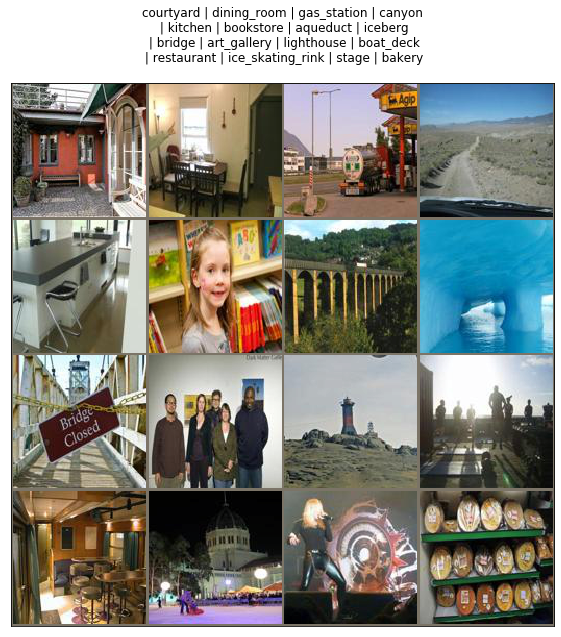

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers before the fully-connected layers in the VGG11 network. 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    layers = []
    # 0-3
    layers.append(nn.Conv2d(3,cfg[0],kernel_size=(3,3),stride=(1,1),padding=(1,1)))
    if (batch_norm):
        layers.append(nn.BatchNorm2d(cfg[0],eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False))
    # 4-7
    layers.append(nn.Conv2d(cfg[0],cfg[2],kernel_size=(3,3),stride=(1,1),padding=(1,1)))
    if (batch_norm):
        layers.append(nn.BatchNorm2d(cfg[2],eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False))
    # 8-10
    layers.append(nn.Conv2d(cfg[2],cfg[4],kernel_size=(3,3),stride=(1,1),padding=(1,1)))
    if (batch_norm):
        layers.append(nn.BatchNorm2d(cfg[4],eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
    layers.append(nn.ReLU(inplace=True))
    # 11-14
    layers.append(nn.Conv2d(cfg[4],cfg[5],kernel_size=(3,3),stride=(1,1),padding=(1,1)))
    if (batch_norm):
        layers.append(nn.BatchNorm2d(cfg[5],eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False))

    features = torch.nn.Sequential(*layers)
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        # Construct the final FC layers using nn.Sequential. 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        self.classifier = torch.nn.Sequential(
            nn.Linear(3200, 512,bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3,inplace=False),
            nn.Linear(512,256,bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3,inplace=False),
            nn.Linear(256, 100,bias=True),
        )
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [ ]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    # Create an Adam optimizer with a learning rate 1e-3
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    optimizer = optim.Adam(model.parameters(), 1e-3)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    # Create an instance of the cross entropy loss function
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # The code should be a one-liner.
    criterion = nn.CrossEntropyLoss()
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
                # For "train" phase, compute the outputs, calculate the loss, update the model parameters
                # For "val" phase, compute the outputs, calculate the loss
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.0695 Acc: 0.0670


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6448 Acc: 0.1203
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.4985 Acc: 0.1512


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2901 Acc: 0.1939
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2503 Acc: 0.1956


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1187 Acc: 0.2238
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0849 Acc: 0.2273


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0303 Acc: 0.2429
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9519 Acc: 0.2536


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9291 Acc: 0.2642
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8344 Acc: 0.2752


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8349 Acc: 0.2894
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7280 Acc: 0.2955


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8856 Acc: 0.2775
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6307 Acc: 0.3170


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8048 Acc: 0.2918
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5361 Acc: 0.3348


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8458 Acc: 0.2895
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4406 Acc: 0.3537


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8414 Acc: 0.2946
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3537 Acc: 0.3681


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8049 Acc: 0.3036
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2763 Acc: 0.3858


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8415 Acc: 0.2939
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1889 Acc: 0.4039


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8727 Acc: 0.2903
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1103 Acc: 0.4176


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9021 Acc: 0.2940
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0322 Acc: 0.4351


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9529 Acc: 0.2952
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9662 Acc: 0.4502


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9795 Acc: 0.2947
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8988 Acc: 0.4668


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0156 Acc: 0.2853
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8451 Acc: 0.4779


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0644 Acc: 0.2918
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7776 Acc: 0.4935


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0527 Acc: 0.2877
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7294 Acc: 0.5025


100%|██████████| 79/79 [00:06<00:00, 11.99it/s]

val Loss: 3.1625 Acc: 0.2763
Best val Acc: 0.303600


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.9188 Acc: 0.0823


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.5170 Acc: 0.1472
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.4970 Acc: 0.1491


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2868 Acc: 0.1849
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3191 Acc: 0.1795


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.3113 Acc: 0.1952
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1968 Acc: 0.2024


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0513 Acc: 0.2332
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0978 Acc: 0.2233


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0423 Acc: 0.2382
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0132 Acc: 0.2384


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9666 Acc: 0.2551
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9386 Acc: 0.2529


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8769 Acc: 0.2702
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8639 Acc: 0.2683


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8949 Acc: 0.2736
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7958 Acc: 0.2809


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7469 Acc: 0.2939
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7359 Acc: 0.2940


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7383 Acc: 0.3033
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6718 Acc: 0.3077


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8047 Acc: 0.2943
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6212 Acc: 0.3166


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7036 Acc: 0.3105
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5659 Acc: 0.3283


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6385 Acc: 0.3238
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5082 Acc: 0.3403


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6203 Acc: 0.3244
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4539 Acc: 0.3518


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5575 Acc: 0.3431
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4051 Acc: 0.3611


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5635 Acc: 0.3371
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3627 Acc: 0.3683


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6116 Acc: 0.3320
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3126 Acc: 0.3794


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5534 Acc: 0.3378
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2655 Acc: 0.3884


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6566 Acc: 0.3286
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2126 Acc: 0.4003


100%|██████████| 79/79 [00:07<00:00, 10.43it/s]

val Loss: 2.5601 Acc: 0.3441
Best val Acc: 0.344100


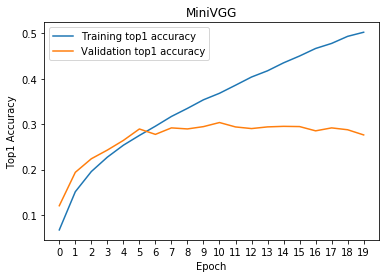

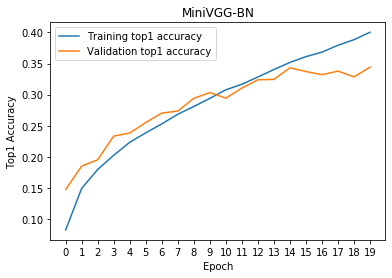

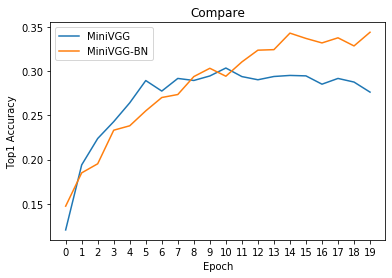

In [ ]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Batch normalization increases the stability of the neural network, speed up the neural network and also improve the performance.

Normalizing the input layer can speed up the learning speed. Normalizing the hidden layers shifts the weight by dividing its mean and covariance, this shift makes the network learn more easily. Also, with the normalization layers, the choice of initialization schemes and learning rate can be more flexible without loosing stability. 

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/100000, sum(top5_acc).item()/100000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 50% #####
# uncomment these two lines to load pretrained weights
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 43.29%, Top-5 accuracy 71.421%
Top-1 accuracy 57.18%, Top-5 accuracy 81.18%
